# Titanic Challenge
Try a classification problem from end to end by working with the Titanic dataset

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [10]:
#Load files

from google.colab import files

uploaded = files.upload()

Saving train.csv to train (1).csv


In [11]:
#Load Data

import io

data = pd.read_csv(io.BytesIO(uploaded['train.csv']))
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Explore

In [0]:
#General Inspection

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


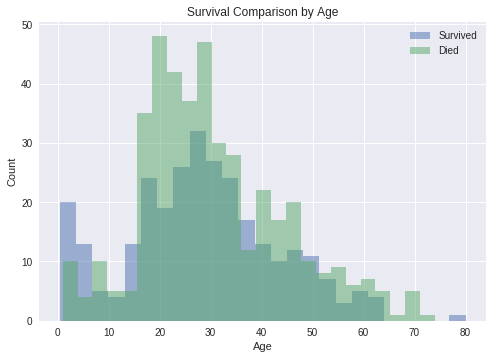

In [0]:
#Investigate survival rates by page

ages = data[data['Age'].notnull()]

plt.hist(ages[ages['Survived'] == 1]['Age'], bins=25, alpha=.5, label='Survived')
plt.hist(ages[ages['Survived'] == 0]['Age'], bins=25, alpha=.5, label='Died')

plt.title('Survival Comparison by Age')
plt.xlabel('Age')
plt.ylabel('Count')
_ = plt.legend()

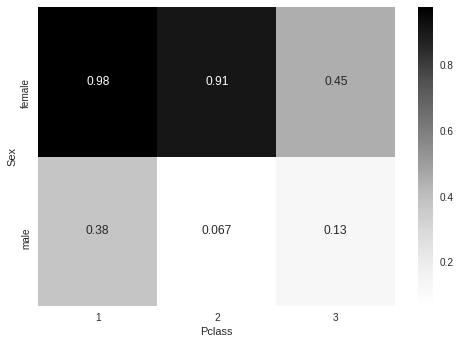

In [0]:
# Survival rate by sex and class, non-children
sx_cl = data[(data['Age'].notnull()) & (data['Age'] >= 15)].groupby(['Sex','Pclass'])['Survived'].mean().reset_index()
_ = sns.heatmap(sx_cl.pivot(index='Sex', columns='Pclass', values='Survived'), cmap='Greys', annot=True)

In [0]:
data['Level'] = data['Cabin'].str.slice(0,1,1)

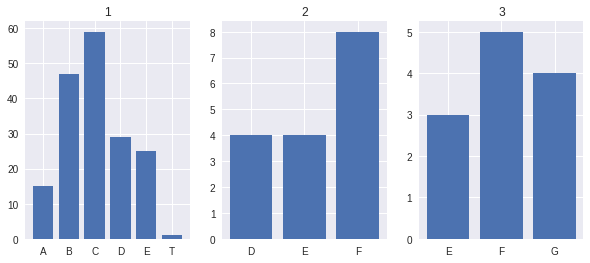

In [0]:
#Cabin level by class

classes = data[data['Level'].notnull()].groupby(['Pclass','Level'])['Survived'].count().reset_index()

plt.figure(figsize=(10,4))

for i, Pclass in enumerate([1,2,3]):
  plt.subplot(1,3,i + 1)
  temp = classes[classes['Pclass'] == Pclass]
  plt.bar(temp['Level'], temp['Survived'])
  plt.title(Pclass)  

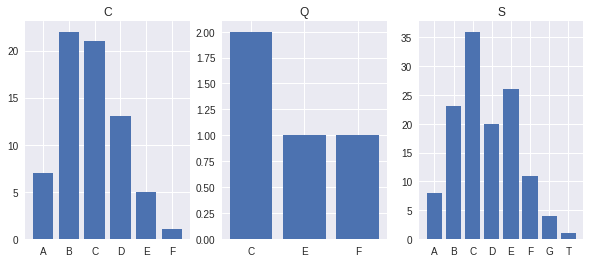

In [0]:
#Cabin levels by port

ports = data[data['Level'].notnull()].groupby(['Embarked','Level'])['Survived'].count().reset_index()

plt.figure(figsize=(10,4))

for i, port in enumerate(['C','Q','S']):
  plt.subplot(1,3,i + 1)
  temp = ports[ports['Embarked'] == port]
  plt.bar(temp['Level'], temp['Survived'])
  plt.title(port)  

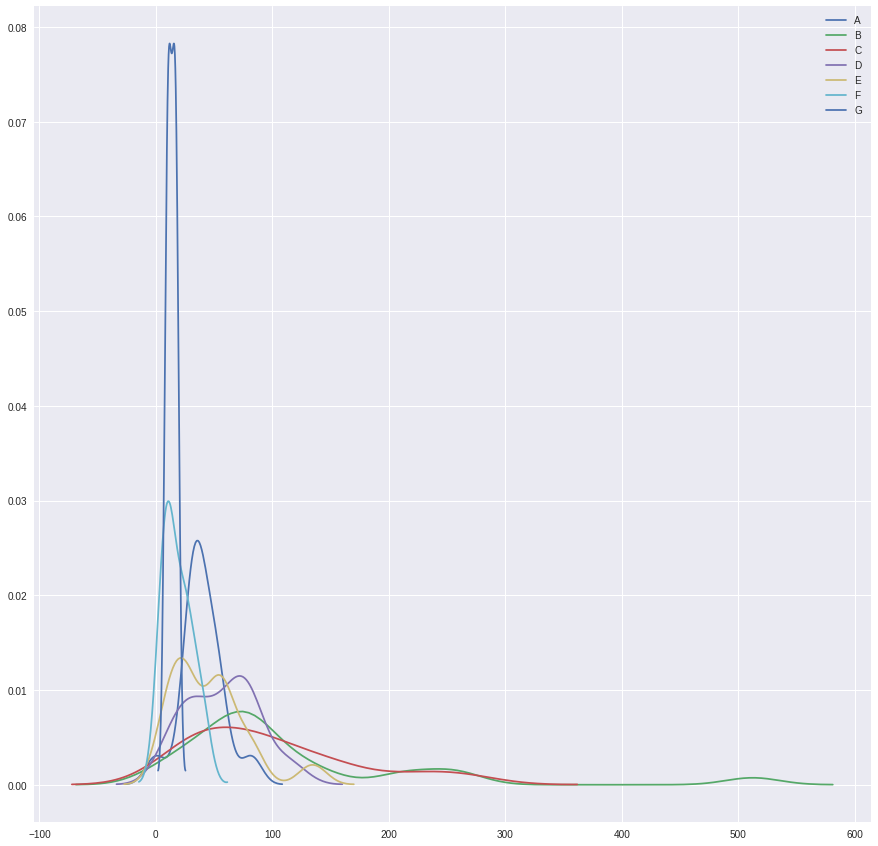

In [0]:
#Look at cabin level based upon fare

plt.figure(figsize=(15,15))

for level in ['A','B','C','D','E','F','G']:
  sns.kdeplot(data[data['Level'] == level]['Fare'], label=level)

plt.legend()

<BarContainer object of 8 artists>

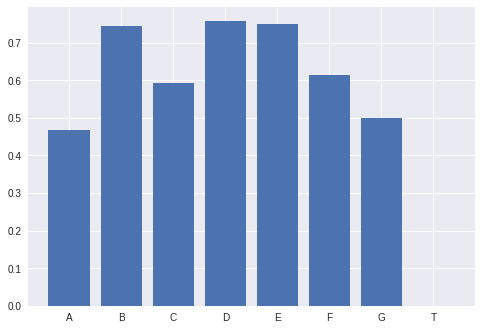

In [0]:
# Survival by cabin level

levels = data.groupby(['Level'])['Survived'].mean()

plt.bar(levels.index, levels)

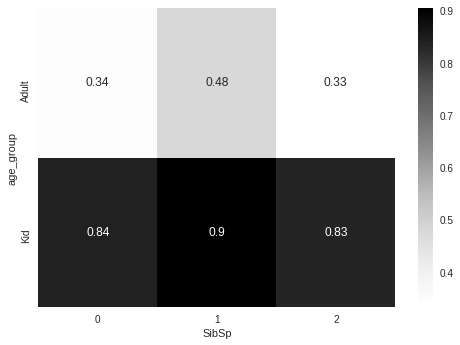

In [0]:
# Peer/sibling relationships

data['age_group'] = np.nan
data.loc[data['Age'] >= 17, 'age_group'] = 'Adult'
data.loc[data['Age'] <= 13, 'age_group'] = 'Kid'

sibs = data.groupby(['age_group','SibSp'])['Survived'].mean().reset_index()
_ = sns.heatmap(sibs.pivot(index='age_group', columns='SibSp', values='Survived')[[0,1,2]], cmap='Greys', annot=True)

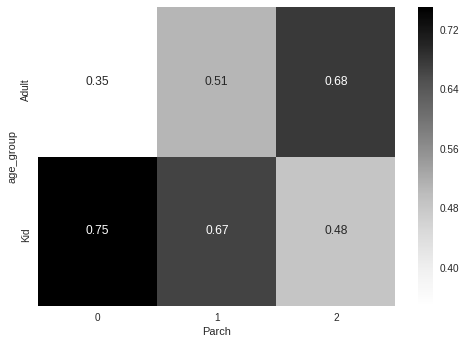

In [0]:
# Parent and child relationships

fam = data.groupby(['age_group','Parch'])['Survived'].mean().reset_index()
_ = sns.heatmap(fam.pivot(index='age_group', columns='Parch', values='Survived')[[0,1,2]], cmap='Greys', annot=True)

# Clean

In [0]:
# Custom transformer methods for the filtering columns and getting Cabin level

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class FilterColumns(BaseEstimator, TransformerMixin):
  def __init__(self, features):
    self.features = features
   
  def fit(self, X, y=None):
    return self
  
  def transform(self, X):
    return X[self.features].values

  
class getLevel(BaseEstimator, TransformerMixin):
  def __init__(self):
    return
  
  def fit(self,X):
    return self
  
  def transform(self,X,y=None):
    X.loc[:,'Cabin'] = X.loc[:,'Cabin'].str.slice(0,1,1)
    return X


class titanicImputer(BaseEstimator, TransformerMixin):
  def __init__(self):
    return
  
  def fit(self, X):
    return self
  
  def transform(self,X,y=None):
    X.loc[:,['Pclass','Sex','Embarked']] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(X.loc[:,['Pclass','Sex','SibSp','Parch','Embarked']])
    X.loc[:,'Cabin'] = X.loc[:,'Cabin'].fillna('U')
    return X

In [0]:
#Build a pipeline for numeric and categorical data
#Combine the cleaned fields into a final prepared dataset

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

num_features = ['Age','SibSp','Parch','Fare']
cat_features = ['Pclass','Sex','Cabin','Embarked']

num = Pipeline([
    ('filter', FilterColumns(num_features)),
    ('imputer', SimpleImputer(strategy='median'))
])

cat = Pipeline([
    ('levels', getLevel()),
    ('imputer',titanicImputer()),
    ('filter', FilterColumns(cat_features)),
    ('encoder', OneHotEncoder(sparse=False))
])

full = FeatureUnion(transformer_list=[
    ('num_pipe', num),
    ('cat_pipe', cat)
])

In [49]:
import itertools

data_cleaned = pd.DataFrame(full.fit_transform(data), columns=num_features + [label for i in range(len(cat.named_steps['encoder'].categories_)) for label in list(cat.named_steps['encoder'].categories_[i])])
data_cleaned.head()

,Age,SibSp,Parch,Fare,1,2,3,female,male,A,...,C,D,E,F,G,T,U,C,Q,S
0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,35.0,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [0]:
#Split into train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_cleaned, data['Survived'], test_size=0.33)

# Model

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[10,50,100],
    'max_depth':[3,5,10,20,None],
    'min_samples_split':[2,10,20],
    'min_samples_leaf':[1,3,5,10],
    'max_leaf_nodes':[None,5,10,50,100]
}

clf = GridSearchCV(RandomForestClassifier(), params, cv=5)

In [0]:
_ = clf.fit(X_train, y_train)

In [54]:
clf.best_score_

0.837248322147651

# Evaluate

In [55]:
clf.best_params_

{'max_depth': 10,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [0]:
y_pred = clf.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.7762711864406779

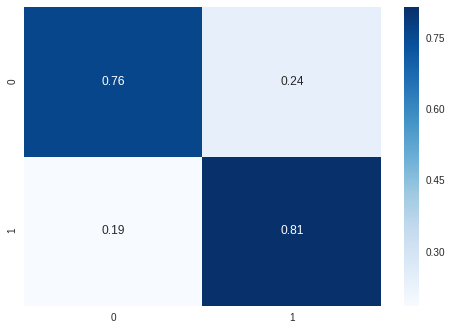

In [59]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

conf_mx = confusion_matrix(y_pred, y_test)
norm_conf_mx = conf_mx / conf_mx.sum(axis=1, keepdims=True)
#np.fill_diagonal(norm_conf_mx, 0)

ax = sns.heatmap(norm_conf_mx, cmap=plt.cm.Blues, annot=True, cbar=True, xticklabels=clf.best_estimator_.classes_, yticklabels=clf.best_estimator_.classes_)